In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Select the folders you want to use
selected_folders = ['happy', 'sad', 'neutral', 'angry']

# Load and preprocess the data
datagen = ImageDataGenerator(rescale=1./255)

# Define the path to the directory containing the images
data_dir = '/content/drive/MyDrive/emotions'

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    classes=selected_folders,  # Filter only selected folders
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)


Found 682 images belonging to 4 classes.


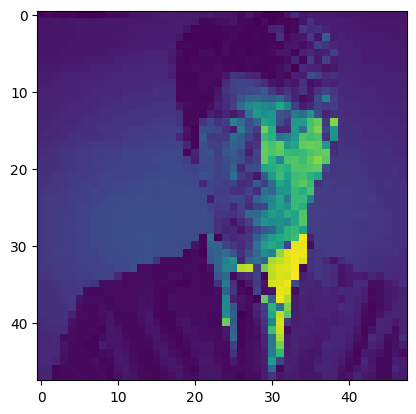

In [3]:
image_list = []

for images, labels in next(zip(data_generator)):
    for i in range(16):  # can't be greater than 20
        image_list.append(images[i])

image_list = np.array(image_list)

plt.imshow(image_list[0], interpolation='nearest')
plt.show()


In [4]:
X, y = [], []
for _ in range(len(data_generator)):
    X_batch, y_batch = data_generator.next()
    X.append(X_batch)
    y.append(y_batch)

X = np.concatenate(X)
y = np.concatenate(y)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

train_classes = y_train.argmax(axis=1)
class_counts = np.bincount(train_classes)
print("Number of samples per class in the training set:")
print(dict(zip(data_generator.class_indices.keys(), class_counts)))


Number of samples per class in the training set:
{'happy': 205, 'sad': 108, 'neutral': 87, 'angry': 145}


In [6]:
def balance_classes(X, y, max_count):
    balanced_X, balanced_y = [], []
    class_counts = np.bincount(y.argmax(axis=1))

    datagen = ImageDataGenerator(
        rescale=1./255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_index in range(len(class_counts)):
        class_X = X[y.argmax(axis=1) == class_index]
        class_y = y[y.argmax(axis=1) == class_index]
        num_samples = len(class_X)

        if num_samples < max_count:
            num_to_generate = max_count - num_samples
            for X_batch, y_batch in datagen.flow(class_X, class_y, batch_size=num_to_generate, shuffle=False):
                class_X = np.concatenate([class_X, X_batch])
                class_y = np.concatenate([class_y, y_batch])
                if len(class_X) >= max_count:
                    class_X = class_X[:max_count]
                    class_y = class_y[:max_count]
                    break

        balanced_X.extend(class_X)
        balanced_y.extend(class_y)

    return np.array(balanced_X), np.array(balanced_y)

max_count = max(class_counts)
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, max_count)

# Show the number of data samples for each class after balancing
balanced_train_classes = y_train_balanced.argmax(axis=1)
balanced_class_counts = np.bincount(balanced_train_classes)
print("Number of samples per class after balancing:")
print(dict(zip(data_generator.class_indices.keys(), balanced_class_counts)))


Number of samples per class after balancing:
{'happy': 205, 'sad': 205, 'neutral': 205, 'angry': 205}


In [7]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(4, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = cnn_model.fit(X_train_balanced, y_train_balanced, validation_data=(X_test, y_test), epochs=100, batch_size=64)


Epoch 1/100
13/13 [==============================] - 60s 4s/step - loss: 1.0610 - accuracy: 0.7988 - val_loss: 1.2512 - val_accuracy: 0.7956
Epoch 2/100
13/13 [==============================] - 51s 4s/step - loss: 1.0448 - accuracy: 0.7768 - val_loss: 1.3495 - val_accuracy: 0.6861
Epoch 3/100
13/13 [==============================] - 50s 4s/step - loss: 1.0307 - accuracy: 0.7829 - val_loss: 1.6513 - val_accuracy: 0.6350
Epoch 4/100
13/13 [==============================] - 49s 4s/step - loss: 1.0464 - accuracy: 0.7768 - val_loss: 1.8102 - val_accuracy: 0.6204
Epoch 5/100
13/13 [==============================] - 51s 4s/step - loss: 1.0299 - accuracy: 0.7793 - val_loss: 1.3472 - val_accuracy: 0.8029
Epoch 6/100
13/13 [==============================] - 49s 4s/step - loss: 1.0673 - accuracy: 0.7793 - val_loss: 1.4317 - val_accuracy: 0.7956
Epoch 7/100
13/13 [==============================] - 49s 4s/step - loss: 1.1935 - accuracy: 0.7537 - val_loss: 1.6254 - val_accuracy: 0.7372
Epoch 8/100
1

In [30]:

model_save_path = 'emotions_model.h5'
cnn_model.save(model_save_path)

print(f'Model saved to {model_save_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Model saved to emotions_model.h5


In [31]:
from google.colab import files

# Download the model
files.download('emotions_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
cnn_test_predict = cnn_model.predict(X_test).argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

print(f'CNN Accuracy: {accuracy_score(y_test_labels, cnn_test_predict)}')

report_cnn = classification_report(y_test_labels, cnn_test_predict, target_names=data_generator.class_indices.keys())
print(report_cnn)

cm_cnn = confusion_matrix(y_test_labels, cnn_test_predict)
cm_df_cnn = pd.DataFrame(cm_cnn, index=data_generator.class_indices.keys(), columns=data_generator.class_indices.keys())

fig_cnn = ff.create_annotated_heatmap(
    z=cm_df_cnn.values,
    x=list(cm_df_cnn.columns),
    y=list(cm_df_cnn.index),
    annotation_text=cm_df_cnn.values,
    colorscale='Blues'
)
fig_cnn.update_layout(title='CNN Confusion Matrix', xaxis_title='Predicted Label', yaxis_title='True Label')
fig_cnn.show()


5/5 [==============================] - 2s 317ms/step
CNN Accuracy: 0.781021897810219
              precision    recall  f1-score   support

       happy       0.88      0.88      0.88        52
         sad       0.81      0.63      0.71        27
     neutral       0.74      0.64      0.68        22
       angry       0.67      0.83      0.74        36

    accuracy                           0.78       137
   macro avg       0.77      0.75      0.75       137
weighted avg       0.79      0.78      0.78       137



1/1 [==============================] - 0s 78ms/step


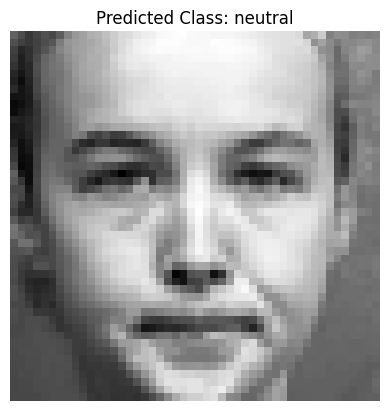

The predicted class for the new image is: neutral


In [14]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

new_image_path = '/content/drive/MyDrive/emotions/neutral/S139_002_00000011.png'  # Path to the new image
predicted_class = predict_image_class(cnn_model, new_image_path, data_generator.class_indices)
print(f'The predicted class for the new image is: {predicted_class}')



Saving net2.jpg to net2.jpg
1/1 [==============================] - 0s 35ms/step


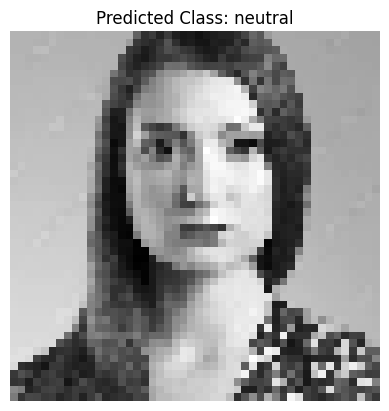

The predicted class for the image net2.jpg is: neutral


In [33]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# Upload multiple images
uploaded_files = files.upload()

# Loop through each uploaded file and predict its class
for filename in uploaded_files.keys():
    predicted_class = predict_image_class(cnn_model, filename, data_generator.class_indices)
    print(f'The predicted class for the image {filename} is: {predicted_class}')


Saving hh.jpg to hh.jpg
1/1 [==============================] - 0s 38ms/step


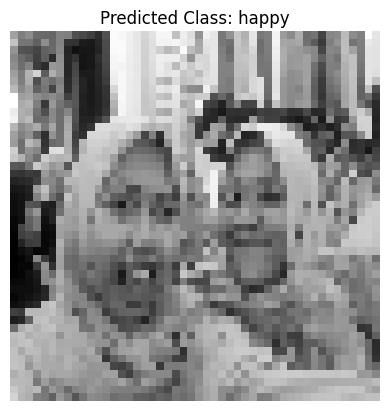

The predicted class for the new image is: happy


In [24]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

uploaded_files = files.upload()

if len(uploaded_files) > 1:
    print("Please upload only one image at a time.")
else:
    new_image_path = list(uploaded_files.keys())[0]
    predicted_class = predict_image_class(cnn_model, new_image_path, data_generator.class_indices)
    print(f'The predicted class for the new image is: {predicted_class}')


Saving sad4.jpg to sad4.jpg
1/1 [==============================] - 0s 72ms/step


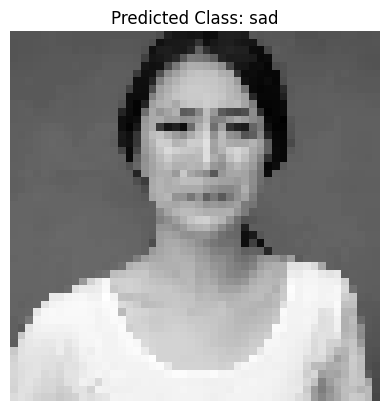

The predicted class for the new image is: sad


In [32]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

uploaded_files = files.upload()

if len(uploaded_files) > 1:
    print("Please upload only one image at a time.")
else:
    new_image_path = list(uploaded_files.keys())[0]
    predicted_class = predict_image_class(cnn_model, new_image_path, data_generator.class_indices)
    print(f'The predicted class for the new image is: {predicted_class}')


Saving an1.jpg to an1 (1).jpg
1/1 [==============================] - 0s 37ms/step


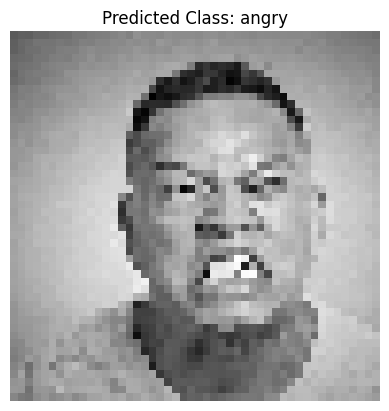

The predicted class for the new image is: angry


In [35]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to create batch of size 1
    return img_array

def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array).argmax(axis=1)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]

    # Display the image and prediction
    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

uploaded_files = files.upload()

if len(uploaded_files) > 1:
    print("Please upload only one image at a time.")
else:
    new_image_path = list(uploaded_files.keys())[0]
    predicted_class = predict_image_class(cnn_model, new_image_path, data_generator.class_indices)
    print(f'The predicted class for the new image is: {predicted_class}')
